# Assignment 4
## Training a DNN for relation classification

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.


**In this work we will use the hugingface framework for transformers training and inference.**
We recomand reading the documentation in [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link *before* you start coding.


All additional packages:

In [ ]:
# !pip install --q
!pip install --q transformers
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=54a165b98dc1d96cbf0c45540177f6a4ba67ea68b0e87e897243c4e04281fd6a
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


All imports: (You may add/change)

In [ ]:
# general
import os
import random
import warnings
from typing import List,Tuple
import copy

# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn

# HF
from transformers import BertTokenizer, AutoConfig
from transformers import BertForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Set warnings filter to ignore:

In [ ]:
warnings.filterwarnings("ignore")

Set random SEEDs:

In [ ]:
SEED = 42

# Set the random seed for Python
random.seed(SEED)

# Set the random seed for numpy
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Set GPU:

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## Dataset


The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [ ]:
!git clone https://github.com/kfirbar/nlp-course

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), 11.28 MiB | 4.41 MiB/s, done.


## Task #1

Write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [ ]:
def read_data(filepath: str) -> List[Tuple[str, str]]:
    data = []
    with open(filepath, 'r', encoding='utf-8') as file:
        file_data = file.read()
    data_list = file_data.split("\n\n")
    for sen in data_list:
        if sen == "":
            continue
        split_sentences = sen.split('\n')
        sentence = split_sentences[0].split("\t")[1][1:-1]
        label = split_sentences[1].split("(")[0]
        data.append((sentence, label))

    return data


train_file = "nlp-course/TRAIN_FILE.TXT"
test_file = "nlp-course/TEST_FILE_FULL.TXT"
train = read_data(train_file)
test = read_data(test_file)

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))

Number of train sentences: 8000
Number of test sentences: 2717


`Pytorch` require the labels to be integers.

Create a mapper (dictionary) from the string labels to integers (starting zero).
And a dictionary from label to integer.

In [ ]:
def create_label_mapper(data):
    label_set = set()
    for _, label in data:
        label_set.add(label)
    label_list = sorted(list(label_set))
    label_mapper = {i: label for i, label in enumerate(label_list)}
    return label_mapper

id2label = create_label_mapper(train)
label2id = {label: i for i, label in id2label.items()}

assert len(id2label) == len(label2id)
print('id2label: \n', id2label)

id2label: 
 {0: 'Cause-Effect', 1: 'Component-Whole', 2: 'Content-Container', 3: 'Entity-Destination', 4: 'Entity-Origin', 5: 'Instrument-Agency', 6: 'Member-Collection', 7: 'Message-Topic', 8: 'Other', 9: 'Product-Producer'}


<br>

Plot the distribution of labels in each dataset.
Display the information in a single plot.

For example:

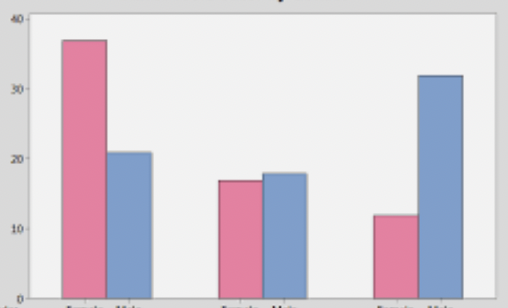

- Use bar plot.
- Use figuresize of (16,6).
- Add titles and Axis names.
- Y-axis will hold the count for each label.
- X-axis will hold the name of each label.

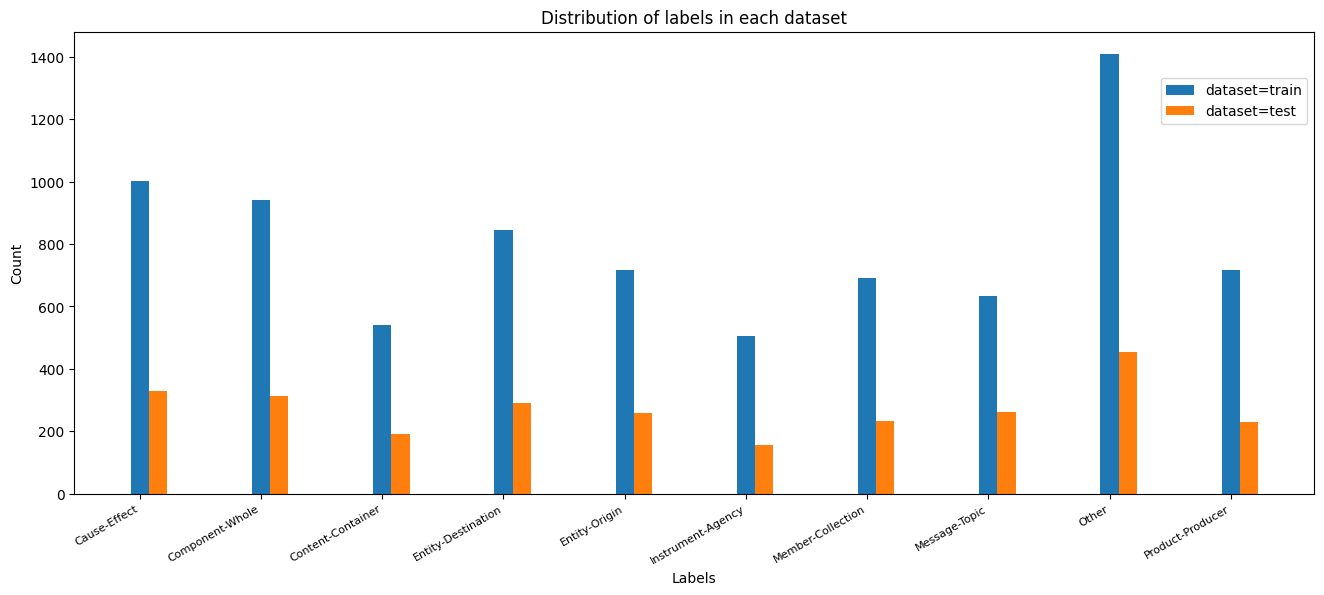

In [ ]:
labels_train = [label for _, label in train]
labels_test = [label for _, label in test]
unique_labels_train, label_counts_train = np.unique(labels_train, return_counts=True)
unique_labels_test, label_counts_test = np.unique(labels_test, return_counts=True)

fig, ax = plt.subplots(figsize=(16, 6))

bar_positions = np.arange(len(unique_labels_train))
bar_width = 0.15
ax.bar(bar_positions + 0 * bar_width, list(label_counts_train), bar_width, label=f'dataset=train')
ax.bar(bar_positions + 1 * bar_width, list(label_counts_test), bar_width, label=f'dataset=test')

ax.set_title("Distribution of labels in each dataset")
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.legend(loc='right', bbox_to_anchor=(1, 0.85))
ax.set_xticks(bar_positions)
ax.set_xticklabels(unique_labels_train, rotation=30, ha='right', fontsize=8)

plt.show()

<br>

<br><br><br><br>


## Task #2

Download the relevant BERT tokenizer.
Use `bert-base-uncased` .


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregate the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

Note: you may use `torch.utils.data.Dataset`

In [ ]:
def prepare_data(data, tokenizer, label2id, max_length, batch_size=8):
    dataset = []
    for index in range(len(data)):
        sentence, label = data[index]
        sentence = sentence.replace("<e1>", "")
        sentence = sentence.replace("</e1>", "")
        sentence = sentence.replace("<e2>", "")
        sentence = sentence.replace("</e2>", "")
        encoded_sequence = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        dataset.append((encoded_sequence['input_ids'][0], encoded_sequence['attention_mask'][0], label2id[label]))

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    return data_loader


max_length = 0
for s, _ in train:
    if len(s) > max_length:
        max_length = len(s)

train, dev = train_test_split(train, test_size=0.1, shuffle=True, random_state=SEED)

train_sequences = prepare_data(train, tokenizer, label2id, max_length)
dev_sequences = prepare_data(dev, tokenizer, label2id, max_length)
test_sequences = prepare_data(test, tokenizer, label2id, max_length)


<br><br><br><br>

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


Download the relevant BERT model. Use `bert-base-uncased` .

In [ ]:
num_labels = len(label2id)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i


Write a function `get_parameters` that gets the model as an input and return the top(final) layer of the model for a `torch` optimizer.

Note: take a look at these links [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [ ]:
def get_parameters(params):
    top_layer_params = []
    for name, param in params:
        if name.startswith('classifier') or name.startswith('bert.pooler') or 'layer.11' in name:
            top_layer_params.append(param)
            param.requires_grad = True
        else:
            param.requires_grad = False
    return top_layer_params


all_model_params = model.named_parameters()
top_layer_params = get_parameters(all_model_params)

Define the optimizer:

- Use the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- Use a learning rate of 0.0001.
- Send only the top/final layer of the model to the optimizer (use `top_layer_params`).


In [ ]:
optimizer = torch.optim.Adam(top_layer_params, lr=0.0001)

<br><br><br><br>

## Task #4

Let's create the trainig function!


1. Write a training function, which takes a the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs.
Use [tqdm](https://github.com/tqdm/tqdm) to mark your iteration and progress.

Notes:
- You may to split the `train` to `train&dev` sets.
- You may change the input/output of the training function.


In [ ]:
def training(model, n_epochs, train_data, dev_data, optimizer=None, criterion=None, is_MTB=False):
    best_accuracy = 0.0
    best_model_weights = None
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    criterion.to(device)

    train_loader = train_data
    dev_loader = dev_data

    for epoch in tqdm(range(n_epochs), desc="Training"):
        model.train()
        train_loss = 0.0

        for i, data in enumerate(train_loader):
            if is_MTB:
                (inputs, attention_mask, labels, e1_starts, e2_starts) = data
                e1_starts = e1_starts.to(device)
                e2_starts = e2_starts.to(device)
            else:
                (inputs, attention_mask, labels) = data
            inputs = inputs.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            if is_MTB:
                outputs = model(inputs, attention_mask, e1_starts, e2_starts)
                loss = criterion(outputs, labels).to(device)
            else:
                outputs = model(inputs, attention_mask)
                loss = criterion(outputs[0], labels).to(device)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        tqdm.write(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}")

        model.eval()
        dev_loss = 0.0
        correct_preds = 0

        with torch.no_grad():
            for data in dev_loader:
                if is_MTB:
                    (inputs, attention_mask, labels, e1_starts, e2_starts) = data
                    e1_starts = e1_starts.to(device)
                    e2_starts = e2_starts.to(device)
                else:
                    (inputs, attention_mask, labels) = data

                inputs = inputs.to(device)
                attention_mask = attention_mask.to(device)
                labels = labels.to(device)

                if is_MTB:
                    outputs = model(inputs, attention_mask, e1_starts, e2_starts)
                    loss = criterion(outputs, labels)
                else:
                    outputs = model(inputs, attention_mask)
                    loss = criterion(outputs[0], labels)

                dev_loss += loss.item() * inputs.size(0)
                if is_MTB:
                    _, preds = torch.max(outputs, 1)
                else:
                    _, preds = torch.max(outputs[0], 1)
                correct_preds += torch.sum(preds == labels.data)

        dev_loss /= len(dev_loader.dataset)
        dev_accuracy = correct_preds.double() / len(dev_loader.dataset)

        tqdm.write(f"Epoch {epoch + 1}/{n_epochs}, Dev Loss: {dev_loss:.4f}, Dev Accuracy: {dev_accuracy:.4f}")
        if dev_accuracy > best_accuracy:
          best_accuracy = dev_accuracy
          best_model_weights = copy.deepcopy(model.state_dict())

    # Load the weights of the best model
    model.load_state_dict(best_model_weights)

<br><br><br><br>

## Task #5

Write an evaluation loop on a trained model, using the test dataset.

Instructions:
> Input: model, data
> Output: Report, Confusion matrix

> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


Explanation:
This function will perform an evaluation over a model with a dataset.
Calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Display a confusion matrix plot: where the predicted labels are the rows, and the true labels are the columns.


In addition, load thwe report to a dataframe and save to a CSV with this name:

> `{student_id_1}_{student_id_n}_part5.csv`
For example: `300123123_200456789_part_5.csv`



In [ ]:
cols = ["precision", "recall", "f1-score", "support"]
labels = ['Other', 'Cause-Effect', 'Component-Whole', 'Content-Container', 'Entity-Destination', 'Entity-Origin',
          'Instrument-Agency', 'Member-Collection', 'Message-Topic', 'Product-Producer']

def evaluate(model, test_data, report_filename, is_MTB=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in test_data:
            if is_MTB:
                (inputs, attention_mask, labels, e1_starts, e2_starts) = data
                e1_starts = e1_starts.to(device)
                e2_starts = e2_starts.to(device)
            else:
                (inputs, attention_mask, labels) = data

            inputs = inputs.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            if is_MTB:
                outputs = model(inputs, attention_mask, e1_starts, e2_starts)
                _, preds = torch.max(outputs, 1)
            else:
                outputs = model(inputs, attention_mask=attention_mask)
                _, preds = torch.max(outputs[0], 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    report = classification_report(true_labels, predicted_labels, target_names=list(label2id.keys()), output_dict=True)

    df = pd.DataFrame(report).transpose()
    df = df[cols]

    print(tabulate(df, headers='keys', tablefmt='psql', floatfmt=".4f"))

    cm = confusion_matrix(true_labels, predicted_labels)
    cm_df = pd.DataFrame(cm, index=list(label2id.keys()), columns=list(label2id.keys()))

    # Display confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")
    plt.show()

    # Save report to CSV
    df.to_csv(report_filename)

    print(f"Evaluation report saved to {report_filename}")

In [ ]:
training(model, 5, train_sequences, dev_sequences, optimizer=optimizer)

Training:   0%|          | 0/5 [04:34<?, ?it/s]

Epoch 1/5, Train Loss: 1.2703


Training:  20%|██        | 1/5 [05:00<20:01, 300.50s/it]

Epoch 1/5, Dev Loss: 0.8271, Dev Accuracy: 0.7125


Training:  20%|██        | 1/5 [09:32<20:01, 300.50s/it]

Epoch 2/5, Train Loss: 0.7707


Training:  40%|████      | 2/5 [09:58<14:57, 299.11s/it]

Epoch 2/5, Dev Loss: 0.7885, Dev Accuracy: 0.7238


Training:  40%|████      | 2/5 [14:29<14:57, 299.11s/it]

Epoch 3/5, Train Loss: 0.5711


Training:  60%|██████    | 3/5 [14:55<09:56, 298.22s/it]

Epoch 3/5, Dev Loss: 0.8037, Dev Accuracy: 0.7475


Training:  60%|██████    | 3/5 [19:27<09:56, 298.22s/it]

Epoch 4/5, Train Loss: 0.4163


Training:  80%|████████  | 4/5 [19:53<04:57, 297.95s/it]

Epoch 4/5, Dev Loss: 0.9092, Dev Accuracy: 0.7300


Training:  80%|████████  | 4/5 [24:24<04:57, 297.95s/it]

Epoch 5/5, Train Loss: 0.2950


Training: 100%|██████████| 5/5 [24:50<00:00, 298.19s/it]

Epoch 5/5, Dev Loss: 0.9994, Dev Accuracy: 0.7263


+--------------------+-------------+----------+------------+-----------+
|                    |   precision |   recall |   f1-score |   support |
|--------------------+-------------+----------+------------+-----------|
| Cause-Effect       |      0.7589 |   0.9116 |     0.8283 |  328.0000 |
| Component-Whole    |      0.7758 |   0.6987 |     0.7352 |  312.0000 |
| Content-Container  |      0.8632 |   0.8542 |     0.8586 |  192.0000 |
| Entity-Destination |      0.8138 |   0.9281 |     0.8672 |  292.0000 |
| Entity-Origin      |      0.7083 |   0.7907 |     0.7473 |  258.0000 |
| Instrument-Agency  |      0.6839 |   0.6795 |     0.6817 |  156.0000 |
| Member-Collection  |      0.7391 |   0.8026 |     0.7695 |  233.0000 |
| Message-Topic      |      0.6686 |   0.8736 |     0.7575 |  261.0000 |
| Other              |      0.5479 |   0.3524 |     0.4290 |  454.0000 |
| Product-Producer   |      0.7263 |   0.5974 |     0.6556 |  231.0000 |
| accuracy           |      0.7269 |   0.7269 |    

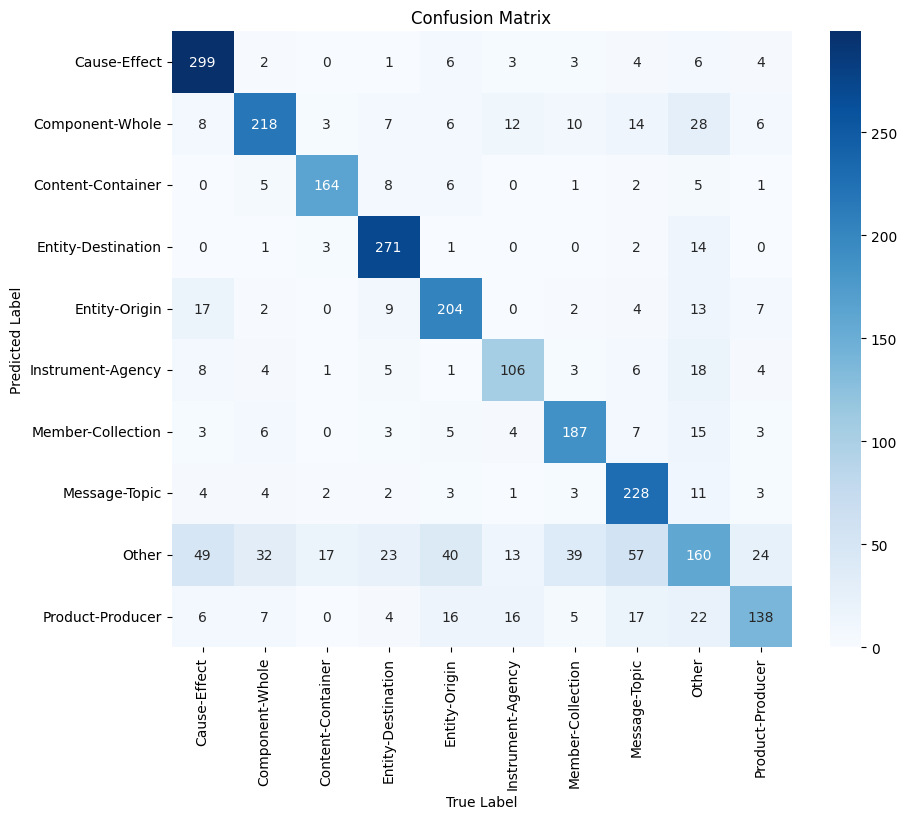

Evaluation report saved to 316550797_312494925_part5.csv


In [ ]:
evaluate(model, test_sequences, f"316550797_312494925_part5.csv")

In [ ]:
# Example:
# results_acc = np.random.rand(10, 4)
# df = pd.DataFrame(results_acc,columns=cols)
# df.index = labels
# print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

<br><br><br><br>

## Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data load and a new model.

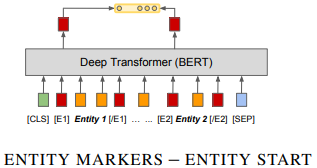

The new methods require the usage of special tokens.
Fix the following code so it will add the required tokens:

In [ ]:
E1_START = '<e1>'
E1_END = '</e1>'
E2_START = '<e2>'
E2_END = '</e2>'

new_tokens = [E1_START, E1_END, E2_START, E2_END]
mtb_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mtb_tokenizer.add_tokens(new_tokens)

4

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

Note: you may change the classes, function, etc.

In [ ]:
class MTBRCDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(MTBRCDataset, self).__init__()

In [ ]:
def prepare_data_MTB(data, tokenizer, label2id, max_length, batch_size=8):
    data_sequences = []
    for index in range(len(data)):
        sentence, label = data[index]
        encoded_sequence = tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = encoded_sequence['input_ids'][0]
        attention_mask = encoded_sequence['attention_mask'][0]
        label = label2id[label]
        s_vals = (tokenizer.added_tokens_encoder[E1_START], tokenizer.added_tokens_encoder[E2_START])
        indxs_starts = (list(input_ids).index(s_vals[0]), list(input_ids).index(s_vals[1]))
        e1_start, e2_start = indxs_starts
        data_sequences.append((input_ids, attention_mask, label, e1_start, e2_start))

    data_sequences = torch.utils.data.DataLoader(data_sequences, batch_size=batch_size)
    return data_sequences


mtb_train_dl = prepare_data_MTB(train, mtb_tokenizer, label2id, max_length)
mtb_dev_dl = prepare_data_MTB(dev, mtb_tokenizer, label2id, max_length)
mtb_test_dl = prepare_data_MTB(test, mtb_tokenizer, label2id, max_length)

In [ ]:
print(len(mtb_train_dl),len(mtb_dev_dl),len(mtb_test_dl))

900 100 340


Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):

    def __init__(self, base_model_name):
        super(MTB, self).__init__()
        config = AutoConfig.from_pretrained(base_model_name, num_labels=num_labels)
        self.model = BertForSequenceClassification.from_pretrained(base_model_name, num_labels=num_labels).bert.to(
            DEVICE)
        self.model.resize_token_embeddings(len(mtb_tokenizer))
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm = nn.LayerNorm(config.hidden_size * 2)
        self.classifier = nn.Linear(config.hidden_size * 2, num_labels)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_ids, attention_mask, e1_start, e2_start):
        outputs = self.model(input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        batch_size = e1_start.size(0)
        e1_output = torch.stack([sequence_output[i][e1_start[i]] for i in range(batch_size)], dim=0)
        e2_output = torch.stack([sequence_output[i][e2_start[i]] for i in range(batch_size)], dim=0)
        e1_and_e2_output = torch.cat((e1_output, e2_output), dim=1)
        e1_and_e2_output = self.LayerNorm(e1_and_e2_output)

        output = self.classifier(e1_and_e2_output)
        return self.softmax(output)

model_MTB = MTB('bert-base-uncased').to(DEVICE)
all_model_params_MTB = model_MTB.named_parameters()
top_layer_params = get_parameters(all_model_params_MTB)
optimizerMTB = torch.optim.Adam(top_layer_params, lr=0.00003)
criterion = nn.CrossEntropyLoss().to(DEVICE)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Use the new dataloader and model to train the new model as in task 4.



**Evaluation**

Use the new dataloader and model to evaluate the new model as in task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report

Use this format:
> `{student_id_1}_{student_id_n}_part6.csv`
> For example: `300123123_200456789_part_6.csv`


Training:   0%|          | 0/5 [04:35<?, ?it/s]

Epoch 1/5, Train Loss: 2.0352


Training:  20%|██        | 1/5 [05:01<20:06, 301.54s/it]

Epoch 1/5, Dev Loss: 1.8237, Dev Accuracy: 0.6488


Training:  20%|██        | 1/5 [09:35<20:06, 301.54s/it]

Epoch 2/5, Train Loss: 1.7834


Training:  40%|████      | 2/5 [10:01<15:02, 300.90s/it]

Epoch 2/5, Dev Loss: 1.7248, Dev Accuracy: 0.7462


Training:  40%|████      | 2/5 [14:36<15:02, 300.90s/it]

Epoch 3/5, Train Loss: 1.7170


Training:  60%|██████    | 3/5 [15:02<10:01, 300.65s/it]

Epoch 3/5, Dev Loss: 1.6982, Dev Accuracy: 0.7712


Training:  60%|██████    | 3/5 [19:36<10:01, 300.65s/it]

Epoch 4/5, Train Loss: 1.6818


Training:  80%|████████  | 4/5 [20:02<05:00, 300.36s/it]

Epoch 4/5, Dev Loss: 1.6863, Dev Accuracy: 0.7838


Training:  80%|████████  | 4/5 [24:36<05:00, 300.36s/it]

Epoch 5/5, Train Loss: 1.6594


Training: 100%|██████████| 5/5 [25:02<00:00, 300.55s/it]


Epoch 5/5, Dev Loss: 1.6784, Dev Accuracy: 0.7888
+--------------------+-------------+----------+------------+-----------+
|                    |   precision |   recall |   f1-score |   support |
|--------------------+-------------+----------+------------+-----------|
| Cause-Effect       |      0.8905 |   0.9177 |     0.9039 |  328.0000 |
| Component-Whole    |      0.8051 |   0.8077 |     0.8064 |  312.0000 |
| Content-Container  |      0.7982 |   0.9062 |     0.8488 |  192.0000 |
| Entity-Destination |      0.8718 |   0.9315 |     0.9007 |  292.0000 |
| Entity-Origin      |      0.7785 |   0.8992 |     0.8345 |  258.0000 |
| Instrument-Agency  |      0.7451 |   0.7308 |     0.7379 |  156.0000 |
| Member-Collection  |      0.7809 |   0.8412 |     0.8099 |  233.0000 |
| Message-Topic      |      0.7883 |   0.9272 |     0.8521 |  261.0000 |
| Other              |      0.6038 |   0.4163 |     0.4928 |  454.0000 |
| Product-Producer   |      0.8178 |   0.7576 |     0.7865 |  231.0000 |
|

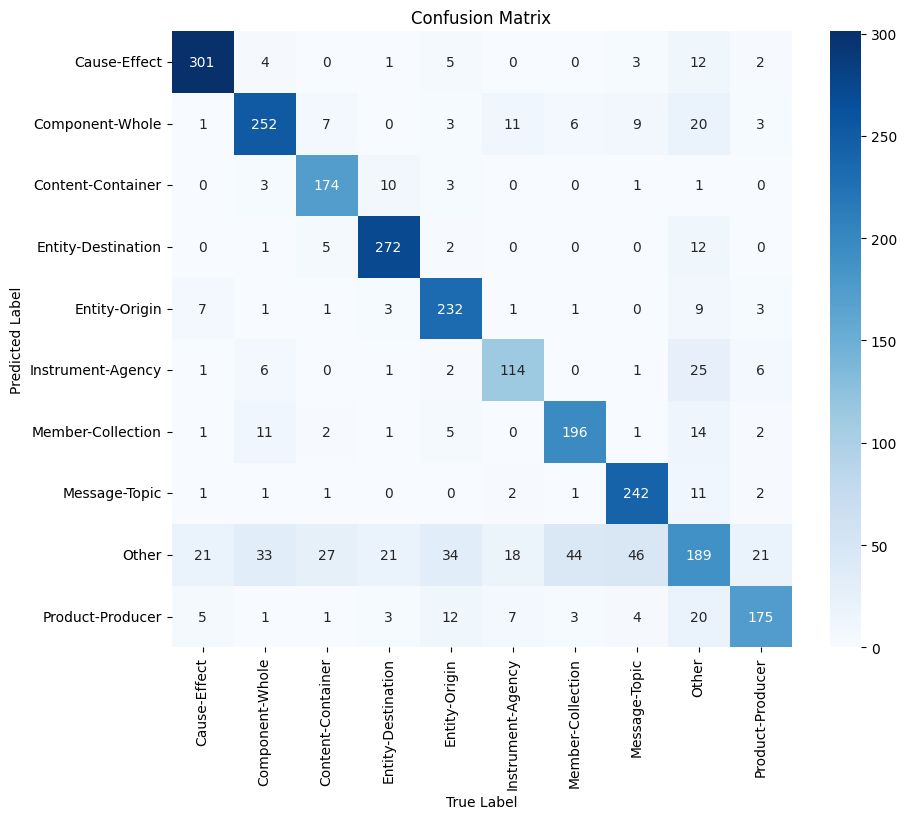

Evaluation report saved to 316550797_312494925_part6.csv


In [ ]:
training(model_MTB, 5, mtb_train_dl, mtb_dev_dl, optimizer=optimizerMTB, is_MTB=True)
evaluate(model_MTB, mtb_test_dl, f"316550797_312494925_part6.csv", is_MTB=True)

<br><br><br><br><br>

## Task #7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

- Get the kaggle dataset and create a inference pipeline for the Sentence similarity. Use an off-the-shelf.

Note: you may add change cells as you pleased.


Optional: Clear GPU space if needed

In [ ]:
torch.cuda.empty_cache()

Set all the relavant random seed to 111

In [ ]:
SEED = 111

# Set the random seed for Python
random.seed(SEED)

# Set the random seed for numpy
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [ ]:
!wget https://raw.githubusercontent.com/saharmilis/runi-nlp/main/kaggle/nlp_2023_train.csv
train_file = '/content/nlp_2023_train.csv'

--2023-07-01 12:26:16--  https://raw.githubusercontent.com/saharmilis/runi-nlp/main/kaggle/nlp_2023_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9621817 (9.2M) [text/plain]
Saving to: ‘nlp_2023_train.csv’

nlp_2023_train.csv  100%[===================>]   9.18M  --.-KB/s    in 0.1s    

2023-07-01 12:26:16 (78.9 MB/s) - ‘nlp_2023_train.csv’ saved [9621817/9621817]



Download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [ ]:
sentences = ["This is an example sentence", "Each sentence is converted"]

embeddings = model.encode(sentences)
cosine_scores = util.cos_sim(embeddings[0], embeddings[1])
print(cosine_scores[0][0])

tensor(0.4049)


Run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

In [ ]:
ROWS_NUMBER = 5000

df_t7 = pd.DataFrame(columns=['ID','LABEL_TRUE','LABEL_PRED'])

df = pd.read_csv(train_file, nrows=ROWS_NUMBER)

#Compute embedding for both lists
text1_embedded = model.encode(np.array(df['text1']), convert_to_tensor=True)
text2_embedded = model.encode(np.array(df['text2']), convert_to_tensor=True)

for i in range(len(text1_embedded)):
    #Compute cosine-similarities
    score = util.cos_sim(text1_embedded[i], text2_embedded[i])[0][0]
    df_t7.loc[i] = {
        "ID": i,
        'LABEL_TRUE': round(df.loc[i]['Similarity']),
        'LABEL_PRED': 1 if score >= 0.8 else 0
    }

Print a classification report (use a simple SK-learn classification report)

In [ ]:
report = classification_report(df_t7['LABEL_TRUE'], df_t7['LABEL_PRED'], output_dict=True)
report_df = pd.DataFrame(report)

report_df

,0,1,accuracy,macro avg,weighted avg
precision,0.857380,0.733501,0.8082,0.795441,0.810653
recall,0.830122,0.772004,0.8082,0.801063,0.808200
f1-score,0.843531,0.752260,0.8082,0.797896,0.809104
support,3114.000000,1886.000000,0.8082,5000.000000,5000.000000


Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`

Notice:
- Do not write the index number to the CSV file.
- Make sure the CSV file will contain only integers.


In [ ]:
# Save report to CSV
report_filename = "316550797_312494925_part7.csv"
df_t7.to_csv(report_filename, index=False)

<br><br><br><br><br><br>
**Good luck!**